In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import line_data
from astropy import constants
import astropy.units as u
import synth
import pymoog
import rulerwd

Module "telfit" is not installed, module "telfit_wrapper" cannot be used. Don't try it :-)


In [13]:
# Linelist compare

vald_1 = line_data.read_linelist('files/linelist/vald/vald_3000_11000.list')
vald_2 = line_data.read_linelist('files/linelist/vald/vald_11000_24000.list')
kurucz = line_data.read_linelist('files/linelist/kurucz/kurucz.list')
mb99_j = line_data.read_linelist('files/linelist/mb99/mb99_j.list')
mb99_k = line_data.read_linelist('files/linelist/mb99/mb99_k.list')
ges_no = line_data.read_linelist('files/linelist/ges/ges_hfs_iso.list')
gex_yes = line_data.read_linelist('files/linelist/ges/ges_nohfs_noiso.list')
apogee = line_data.read_linelist('files/linelist/apogee/apogee.list')

In [17]:
def get_linelist_info(linelist):
    wav = [min(linelist['wavelength']), max(linelist['wavelength'])]
    if len(linelist[linelist['id'] > 118]) > 0:
        molecular = True
    else:
        molecular = False
    num = len(linelist)
    return wav, molecular, num

In [19]:
ll_info = get_linelist_info(kurucz)
plt.plot()

([1000.016, 699991.22], False, 1930074)

In [9]:
solar_spec = pd.read_csv('solar_temp.txt', sep=' ', names=['wavelength', 'flux'])
solar_spec['flux'] = solar_spec['flux'] / max(solar_spec['flux'])

s = synth.synth(5777, 4.43, 0, min(solar_spec['wavelength']), max(solar_spec['wavelength']), 100000, line_list='kurucz')
s.prepare_file()
s.run_moog()
s.read_spectra()

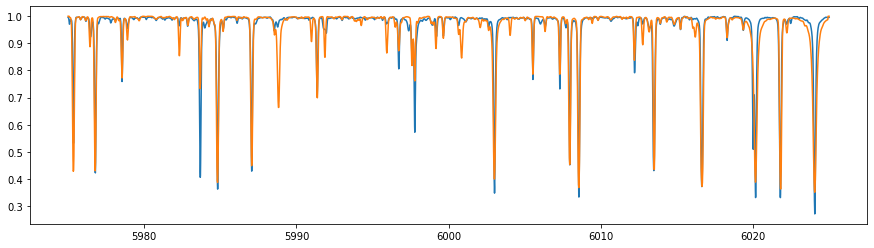

In [6]:
plt.figure(figsize=(15,4))
plt.plot(solar_spec['wavelength'], solar_spec['flux'])
plt.plot(s.wav, s.flux)

# for i in range(len(linelist_single)):
#     plt.axvline(linelist_single.loc[i, 'wavelength'], ls='--', zorder=0, c='red')

# plt.xlim(7000,7010)

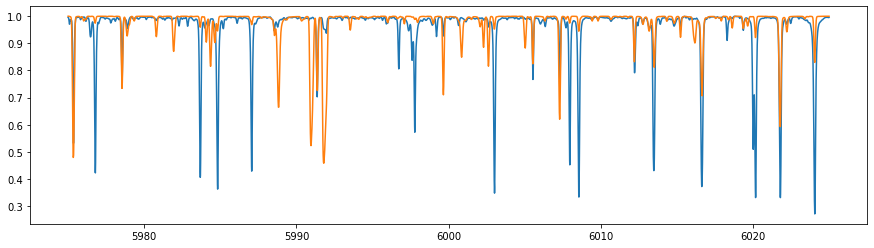

In [10]:
plt.figure(figsize=(15,4))
plt.plot(solar_spec['wavelength'], solar_spec['flux'])
plt.plot(s.wav, s.flux)

In [58]:
vald = rulerwd.moog.read_vald_linelist()
vald_sub = vald[np.abs(vald['wavelength'] - 9025) < 25]
vald_sub['EW'] = 0
vald_pm = pymoog.line_data.read_linelist('vald_3000_11000')
vald_pm_sub = vald_pm[np.abs(vald_pm['wavelength'] - 9025) < 25]

In [59]:
vald_sub

,wavelength,id,EP,loggf,C6,D0,EW
0,9000.0069,26.10000,12.8570,-2.962,-7.350,NaN,0
1,9000.0191,39.10000,8.7526,-0.317,-7.420,NaN,0
2,9000.0296,26.10000,14.0757,-6.928,-7.350,NaN,0
3,9000.0402,108.00116,2.8936,-12.170,0.000,4.395,0
4,9000.0418,29.00000,7.4478,-3.138,-6.840,NaN,0
...,...,...,...,...,...,...,...
1917,9049.8470,108.00116,1.3508,-6.491,0.000,4.395,0
1918,9049.8782,23.00000,3.8878,-8.194,-7.440,NaN,0
1919,9049.8890,7.00000,12.3568,0.283,-7.425,NaN,0
1920,9049.9109,24.10000,13.3539,-5.431,-7.400,NaN,0


In [60]:
pymoog.line_data.save_linelist(vald_sub, 'vald_list')

In [53]:
vald_pm_sub

,wavelength,id,EP,loggf,C6,D0,EW
529419,9000.007,26.10000,12.857,-2.962,-7.350,NaN,0.00
529420,9000.019,39.10000,8.753,-0.317,-7.420,NaN,0.00
529421,9000.030,26.10000,14.076,-6.928,-7.350,NaN,0.00
529422,9000.040,108.00116,2.894,-12.170,0.000,4.456,0.00
529423,9000.091,606.01212,2.046,-6.177,0.000,6.408,0.00
...,...,...,...,...,...,...,...
530938,9049.839,26.10000,12.702,-2.963,-7.420,NaN,0.00
530939,9049.847,108.00116,1.351,-6.491,0.000,4.456,0.00
530940,9049.878,23.00000,3.888,-8.194,-7.440,NaN,0.00
530941,9049.889,7.00000,12.357,0.283,499.229,NaN,0.23


In [14]:
linelist = pymoog.line_data.read_linelist('~/.pymoog/rundir/line.list')
linelist_single = linelist[linelist['id'] == 14].reset_index(drop=True)
linelist_single = linelist_single.loc[[0,1,4,5,7,9]].reset_index(drop=True)

In [19]:
i = 5
EW_list = []
for i in range(len(linelist_single)):
    spec_width = 0.225
    tar_wav = linelist_single.loc[i, 'wavelength']
    del_wav = solar_spec.loc[1, 'wavelength'] - solar_spec.loc[0, 'wavelength']
    # plt.plot(solar_spec['wavelength'], solar_spec['flux'])
    # plt.xlim(tar_wav-2, tar_wav+2)
    # plt.axvspan(tar_wav-spec_width, tar_wav+spec_width, color='red', alpha=0.3)
    EW = np.sum(1 - solar_spec.loc[np.abs(solar_spec['wavelength']-tar_wav)<=spec_width, 'flux']) * del_wav * 1000
    EW_list.append(EW)

In [20]:
linelist_single['EW'] = EW_list
pymoog.line_data.save_linelist(linelist_single, '/home/mingjie/.pymoog/rundir/line_single.list')

In [21]:
pymoog.line_data.read_linelist('vald_3000_11000')

,wavelength,id,EP,loggf,C6,D0,EW
0,3000.003,26.00000,3.301,-4.032,-7.28,NaN,0.89
1,3000.004,606.01212,0.091,-16.576,0.00,6.408,0.00
2,3000.020,26.00000,3.332,-9.098,-7.18,NaN,0.00
3,3000.021,26.00000,3.332,-7.178,-7.18,NaN,0.00
4,3000.028,25.10000,9.413,-8.300,-7.33,NaN,0.00
...,...,...,...,...,...,...,...
591474,10999.911,108.00116,1.305,-14.634,0.00,4.456,0.00
591475,10999.925,606.01212,1.856,-11.319,0.00,6.408,0.00
591476,10999.938,39.10000,10.044,-5.557,-7.11,NaN,0.00
591477,10999.971,608.01217,2.570,-11.809,0.00,11.156,0.00


In [21]:
s = synth.synth(4500, 2.5, 0, 11020, 13000, 28000, line_list='vald_11000_24000')
s.prepare_file()
linelist = pymoog.line_data.read_linelist('~/.pymoog/rundir/line.list')
linelist = linelist[linelist['id'] == 6].reset_index(drop=True)
pymoog.line_data.save_linelist(linelist, '/home/mingjie/.pymoog/rundir/line.list')
s.run_moog(output=True)
s.read_spectra()

*******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER synth  
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
RAW SYNTHESIS OUTPUT; here is the filename: MOOG.out2                           
SMOOTHED SYNTHESES OUTPUT; here is the filename: MOOG.out3                      
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [20]:
linelist

,wavelength,id,EP,loggf,C6,D0,EW
0,11021.932,6.0,10.0223,-3.687,-6.580,NaN,0.00
1,11022.132,6.0,9.6892,-4.302,-6.980,NaN,0.00
2,11049.703,6.0,9.7073,-3.772,-6.950,NaN,0.00
3,11056.708,6.0,8.6405,-2.406,815.272,NaN,0.98
4,11070.013,6.0,9.7615,-1.591,-6.980,NaN,0.74
...,...,...,...,...,...,...,...
536,12966.438,6.0,10.0855,-4.508,-6.760,NaN,0.00
537,12970.560,6.0,7.6848,-2.954,545.239,NaN,2.85
538,12971.930,6.0,10.0223,-4.279,-6.860,NaN,0.00
539,12987.933,6.0,10.0182,-2.677,-6.860,NaN,0.05
